In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm


class EMAlgorithmWithNNet:
    def __init__(self, x, betahat, sd_noise, hidden_dim=16, lr=0.01, max_iter=100, tol=1e-6):
        # Ensure x is 2D
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        self.x = torch.tensor(x, dtype=torch.float32)
        self.betahat = betahat
        self.sd_noise = sd_noise
        self.max_iter = max_iter
        self.tol = tol

        # Initialize Gaussian parameters
        self.mu_2 = np.mean(betahat)
        self.sigma_2_sq = np.var(betahat)

        # Neural network for π(x)
        self.pi_net = nn.Sequential(
            nn.Linear(self.x.shape[1], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )
        self.optimizer = optim.Adam(self.pi_net.parameters(), lr=lr)

    def e_step(self):
        """
        E-step: Compute posterior probabilities (responsibilities) q_i.
        """
        # Predict \(\pi(x)\) using the neural network
        self.pi_net.eval()
        with torch.no_grad():
            pi_2 = self.pi_net(self.x).squeeze().numpy()
        pi_1 = 1 - pi_2

        # Total variance for the Gaussian component
        total_var_2 = self.sigma_2_sq + self.sd_noise**2

        # Compute likelihoods
        p1 = norm.pdf(self.betahat, 0, self.sd_noise)  # Point mass likelihood
        p2 = norm.pdf(self.betahat, self.mu_2, np.sqrt(total_var_2))  # Gaussian likelihood

        # Posterior probabilities (responsibilities)
        q = (pi_2 * p2) / (pi_1 * p1 + pi_2 * p2 + 1e-8)  # Add epsilon for stability
        return q, pi_1, pi_2

    def m_step(self, q):
        """
        M-step: Update parameters using current responsibilities.
        """
        # Update neural network for \(\pi(x)\) using current responsibilities
        self.pi_net.train()
        q_tensor = torch.tensor(q, dtype=torch.float32)  # Ensure same shape as pi_2
        for _ in range(100):  # Fixed number of optimization steps
            self.optimizer.zero_grad()
            pi_2 = self.pi_net(self.x).squeeze()
            loss = nn.BCELoss()(pi_2, q_tensor)  # Binary cross-entropy loss
            loss.backward()
            self.optimizer.step()

        # Update mu_2 (Gaussian mean)
        self.mu_2 = np.sum(q * self.betahat) / np.sum(q)

        # Update sigma_2_sq (Gaussian variance)
        total_var = np.sum(q * (self.betahat - self.mu_2) ** 2) / np.sum(q)
        self.sigma_2_sq = max(total_var - self.sd_noise**2, 1e-8)  # Ensure non-negative variance

    def run(self):
        """
        Run the EM algorithm until convergence.

        Returns:
        - pi_net: Trained neural network for \(\pi(x)\).
        - mu_2: Estimated mean of the Gaussian component.
        - sigma_2_sq: Estimated variance of the Gaussian component.
        """
        for iteration in range(self.max_iter):
            # E-step
            q, pi_1, pi_2 = self.e_step()

            # Save old parameters to check for convergence
            old_params = np.array([self.mu_2, self.sigma_2_sq])

            # M-step
            self.m_step(q)

            # Check convergence
            new_params = np.array([self.mu_2, self.sigma_2_sq])
            if np.linalg.norm(new_params - old_params) < self.tol:
                print(f"Converged in {iteration + 1} iterations.")
                break
        else:
            print("Maximum iterations reached without convergence.")

        return self.pi_net, self.mu_2, self.sigma_2_sq
 

In [4]:
# Generate synthetic data
np.random.seed(42)
n_samples = 5000
mu_2_true, sigma_2_sq_true = np.random.normal(2, 1), np.random.uniform(0.5, 1.5)
sd_noise = 1.5

# Covariates and mixture probabilities
x = np.random.uniform(-3, 3, n_samples)
true_a, true_b = 3.0, -0.5
pi_2_true = 1 / (1 + np.exp(-(true_a * x + true_b)))
pi_1_true = 1 - pi_2_true

    # Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)
for i in range(n_samples):
        c[i] = np.random.choice([0, 1], p=[pi_1_true[i], pi_2_true[i]])
        if c[i] == 0:
            y[i] = 0
            betahat[i] = y[i] + np.random.normal(0, sd_noise)
        else:
            y[i] = np.random.normal(mu_2_true, np.sqrt(sigma_2_sq_true))
            betahat[i] = y[i] + np.random.normal(0, sd_noise)

    # Run the EM algorithm
em = EMAlgorithmWithNNet(x, betahat, sd_noise)
pi_net, mu_2, sigma_2_sq = em.run()

    # Print results
print(f"Estimated \u03bc_2: {mu_2}, True \u03bc_2: {mu_2_true}")
print(f"Estimated \u03c3^2_2: {sigma_2_sq}, True \u03c3^2_2: {sigma_2_sq_true}")

    # Visualize learned pi(x)
x_sorted = np.sort(x)
with torch.no_grad():
        pi_2_est = pi_net(torch.tensor(x_sorted, dtype=torch.float32).unsqueeze(1)).squeeze().numpy()




Maximum iterations reached without convergence.
Estimated μ_2: 2.469399431795488, True μ_2: 2.496714153011233
Estimated σ^2_2: 1.238211570671571, True σ^2_2: 1.231993941811405


NameError: name 'plt' is not defined

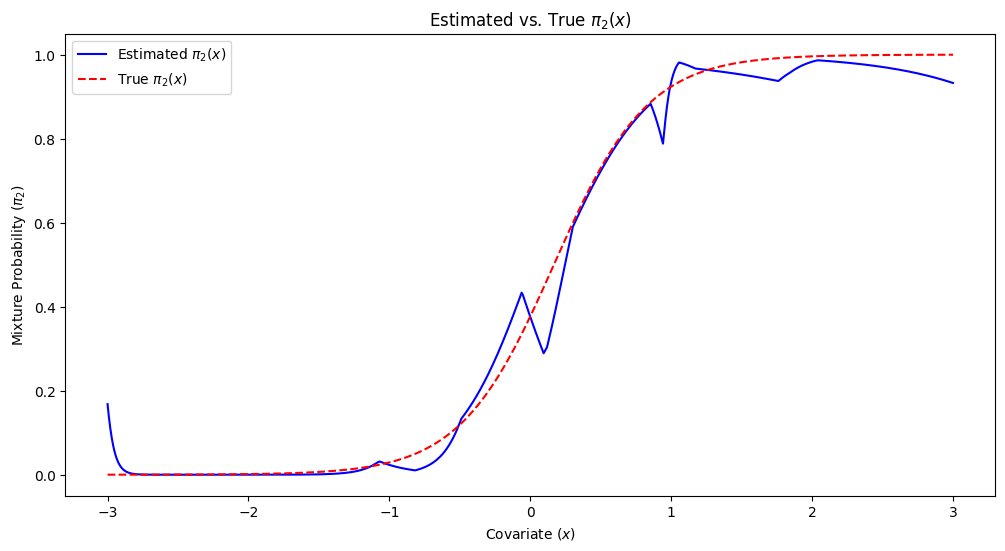

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(x_sorted, pi_2_est, label="Estimated $\pi_2(x)$", color="blue")
plt.plot(x_sorted, 1 / (1 + np.exp(-(true_a * x_sorted + true_b))), "--", label="True $\pi_2(x)$", color="red")
plt.xlabel("Covariate ($x$)")
plt.ylabel("Mixture Probability ($\pi_2$)")
plt.legend()
plt.title("Estimated vs. True $\pi_2(x)$")
plt.show()